In [339]:
!pip install nltk
!pip install category_encoders
!pip install --upgrade sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [340]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.model_selection import cross_val_score

from scipy import stats

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import nltk
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')
download('punkt')
nltk.download("stopwords")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [341]:
data = pd.read_csv('ApartmentRentPrediction.csv')
#data = pd.read_csv('updatedApartmentRentPrediction.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             9000 non-null   int64  
 1   category       9000 non-null   object 
 2   title          9000 non-null   object 
 3   body           9000 non-null   object 
 4   amenities      5815 non-null   object 
 5   bathrooms      8970 non-null   float64
 6   bedrooms       8993 non-null   float64
 7   currency       9000 non-null   object 
 8   fee            9000 non-null   object 
 9   has_photo      9000 non-null   object 
 10  pets_allowed   5249 non-null   object 
 11  price          9000 non-null   int64  
 12  price_display  9000 non-null   object 
 13  price_type     9000 non-null   object 
 14  square_feet    9000 non-null   int64  
 15  address        6029 non-null   object 
 16  cityname       8934 non-null   object 
 17  state          8934 non-null   object 
 18  latitude

In [342]:
data.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9.000000e+03,8970.000000,8993.000000,9000.000000,9000.000000,8993.00000,8993.000000,9.000000e+03
mean,5.623668e+09,1.380769,1.744023,1487.286222,947.138667,37.67689,-94.778612,1.574906e+09
std,7.007402e+07,0.616171,0.942446,1088.561190,668.806214,5.51527,15.769232,3.755142e+06
min,5.508654e+09,1.000000,0.000000,200.000000,106.000000,21.31550,-158.022100,1.568744e+09
25%,5.509250e+09,1.000000,1.000000,950.000000,650.000000,33.66200,-101.858700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1275.000000,802.000000,38.75550,-93.707700,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.34980,-82.446800,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.59400,-70.191600,1.577362e+09


In [343]:
data.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,USD,No,Thumbnail,...,"$1,194",Monthly,800,NaN,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,USD,No,Thumbnail,...,"$1,370",Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,USD,No,Thumbnail,...,"$1,009",Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",NaN,1.0,1.0,USD,No,Thumbnail,...,$695,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",NaN,3.0,3.0,USD,No,Thumbnail,...,"$3,695",Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159


In [344]:
print(data.isnull().sum())

id                  0
category            0
title               0
body                0
amenities        3185
bathrooms          30
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     3751
price               0
price_display       0
price_type          0
square_feet         0
address          2971
cityname           66
state              66
latitude            7
longitude           7
source              0
time                0
dtype: int64


In [345]:
data.duplicated().sum()

0

In [346]:
data['address'].nunique()

6016

In [347]:
data['address'].value_counts()

address
500 Sleepy Hollow Rd           3
908 8th SW St                  3
7098 Fernwood St               2
2571 Lake Worth Road           2
#4 Pahrump Valley Boulevard    2
                              ..
8 South 8th St                 1
277-279 Columbus Ave           1
9860 Fairfax Square            1
5700 S Blackstone Avenue       1
5505 Zelzah Ave                1
Name: count, Length: 6016, dtype: int64

In [348]:
#replacing the null values:

#replacing with none as null here has meaning of not having those features
data['pets_allowed'].fillna('none', inplace=True)
data['amenities'].fillna('none', inplace=True)

#replacing with mode even if numeric as it is descrete and not continuous
data['bathrooms'] = data['bathrooms'].fillna(data['bathrooms'].mode().iloc[0])
data['bedrooms'] = data['bedrooms'].fillna(data['bedrooms'].mode().iloc[0])
#replacing float with int for logical reasons and data integrity
data['bathrooms'] = data['bathrooms'].astype(int)
data['bedrooms'] = data['bathrooms'].astype(int)

#replacing categorical data with mode
#data['cityname'] = data['cityname'].fillna(data['cityname'].mode().iloc[0])
#data['state'] = data['state'].fillna(data['state'].mode().iloc[0])

#replacing continuous data with mean
data['latitude'] = data['latitude'].fillna(data['latitude'].mean())
data['longitude'] = data['longitude'].fillna(data['longitude'].mean())

#doesn't make sense to me: the number of unique addresses is large and the highest repetition is only 3 -> replacing all the null values with it will break the integrity of the data and have 3000 listing with the same address

#data['address'] = data['address'].fillna(data['address'].mode().iloc[0])
#data['address'].fillna('Unknown', inplace=True)

In [349]:
print(data.isnull().sum())

id                  0
category            0
title               0
body                0
amenities           0
bathrooms           0
bedrooms            0
currency            0
fee                 0
has_photo           0
pets_allowed        0
price               0
price_display       0
price_type          0
square_feet         0
address          2971
cityname           66
state              66
latitude            0
longitude           0
source              0
time                0
dtype: int64


In [350]:
geolocator = Nominatim(user_agent="reverse_geocoding", timeout=90)

def reverse_geocode(latitude, longitude):
    max_retries = 3
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.reverse((latitude, longitude), language='en')
            return location.address
        except GeocoderTimedOut:
            retries += 1
            print(f"Geocoder timed out. Retrying... Attempt {retries}/{max_retries}")
    print("Max retries exceeded. Unable to geocode.")
    return None

null_address_rows = data[data['address'].isnull()]

batch_size = 100
for i in range(0, len(null_address_rows), batch_size):
    batch_data = null_address_rows.iloc[i:i+batch_size]
    for index, row in batch_data.iterrows():
        latitude = row['latitude']
        longitude = row['longitude']
        address = reverse_geocode(latitude, longitude)
        if address:
            data.at[index, 'address'] = address
            print(f"New address added at index {index}: {address}")

New address added at index 0: Southeast Cary Parkway, Ridgepath, Cary, Wake County, North Carolina, 27511, United States
New address added at index 6: Red Oaks playground, 29th Avenue West, Snohomish County, Washington, 98087, United States
New address added at index 10: 620, North Shore Road, Virginia Gardens, Norfolk, Virginia, 23505, United States
New address added at index 12: 6527, Westgate Drive, Dallas, Dallas County, Texas, 75254, United States
New address added at index 14: Christus Saint Michael, 2600, Saint Michael Drive, Texarkana, Bowie County, Texas, 75503, United States
New address added at index 17: 3231, Brotherton Road, Oakley Business District, Oakley, Cincinnati, Hamilton County, Ohio, 45209, United States
New address added at index 18: Bear Swamp Trail, Hamilton Township, Mercer County, New Jersey, 08648, United States
New address added at index 30: 8821, Directors Row, Dallas, Dallas County, Texas, 75247, United States
New address added at index 32: 737, Californi

In [351]:
# preprocessing  body coulmn

pattern = r'is located at\s*.*?,(.*?),'

# Extract city names
city_name_from_body = data['body'].str.extract(pattern)
city_name_from_body = np.array(city_name_from_body)
city_name_from_body_series = pd.Series(city_name_from_body.flatten())

#print(city_name_from_body_series)
print(data['cityname'].isnull().sum())
data['cityname'].fillna(city_name_from_body_series, inplace = True)
print(data['cityname'].isnull().sum())
data['cityname'] = data['cityname'].fillna(data['cityname'].mode().iloc[0])

#Extract state
pat = r'(\b[A-Z]{2}\b)'
state_from_body = data['body'].str.extractall(pat)
state_from_body = np.array(state_from_body)
state_from_body_series = pd.Series(state_from_body.flatten())
data['state'].fillna(state_from_body_series, inplace=True)

#print(state_from_body_series.notnull())
print(data['state'].isnull().sum())
data['state'].fillna(data['state'].mode().iloc[0], inplace=True)
print(data['state'][187])

66
2
51
TX


In [352]:
print(data.isnull().sum())

id               0
category         0
title            0
body             0
amenities        0
bathrooms        0
bedrooms         0
currency         0
fee              0
has_photo        0
pets_allowed     0
price            0
price_display    0
price_type       0
square_feet      0
address          0
cityname         0
state            0
latitude         0
longitude        0
source           0
time             0
dtype: int64


In [353]:
data['address'].nunique()

7060

In [354]:
data['address'].value_counts() #compare the difference before and after replacing null with mode to understand note

address
3409, Mills Avenue, Bryker Woods, Austin, Travis County, Texas, 78703, United States                                                      46
Beacon Way, The Beacon, Jersey City, Hudson County, New Jersey, 07306, United States                                                      34
South Pipeline Road, Euless, Tarrant County, Texas, 76040, United States                                                                  28
Union Street, Manchester, Hillsborough County, New Hampshire, 03104, United States                                                        20
Ridgewood Mobile Home Park, Ridge Road, Dorsey Ridge, Shipley Corner, Glen Burnie, Anne Arundel County, Maryland, 21077, United States    20
                                                                                                                                          ..
930 East 15th St                                                                                                                           1
201 W

In [355]:
data['pets_allowed'].nunique()

4

In [356]:
data['pets_allowed'].value_counts()

pets_allowed
Cats,Dogs    4702
none         3751
Cats          433
Dogs          114
Name: count, dtype: int64

In [357]:
data['amenities'].nunique()

2094

In [358]:
data['cityname'].nunique()

1543

In [359]:
data['cityname'].value_counts()

cityname
Austin          484
Dallas          194
Houston         173
San Antonio     169
Los Angeles     151
               ... 
Westchase         1
O Fallon          1
Sanford           1
Collingswood      1
Camas             1
Name: count, Length: 1543, dtype: int64

In [360]:
data['has_photo'].nunique()

3

In [361]:
data['has_photo'].value_counts()

has_photo
Thumbnail    8025
Yes           816
No            159
Name: count, dtype: int64

In [362]:
data['price_type'].nunique()

3

In [363]:
data['price_type'].value_counts()

price_type
Monthly           8998
Weekly               1
Monthly|Weekly       1
Name: count, dtype: int64

In [364]:
data['currency'].nunique()

1

In [365]:
data['category'].nunique()

3

In [366]:
data['category'].value_counts()

category
housing/rent/apartment     8997
housing/rent/short_term       2
housing/rent/home             1
Name: count, dtype: int64

In [367]:
data['fee'].value_counts()

fee
No    9000
Name: count, dtype: int64

In [368]:
data['state'].nunique()

59

In [369]:
data['state'].value_counts()

state
TX    1639
CA     863
WA     471
NC     401
MD     373
NJ     343
GA     332
FL     297
CO     292
OH     284
WI     264
IL     262
IN     217
MO     215
MN     201
OR     184
VA     182
IA     163
MI     162
PA     161
OK     154
MA     138
AZ     115
NV     108
ND      97
NE      89
CT      89
TN      86
KS      76
UT      74
DC      72
SC      71
NY      63
NH      61
LA      61
SD      59
AR      54
AL      52
AK      42
KY      40
ID      16
VT      14
HI      11
RI      10
NM       9
MS       7
MT       7
DE       5
WV       3
ST       2
US       1
SW       1
NO       1
PL       1
UP       1
RD       1
GE       1
LN       1
WY       1
Name: count, dtype: int64

In [370]:
data['source'].nunique()

11

In [371]:
data['source'].value_counts()

source
RentLingo            6232
RentDigs.com         2474
ListedBuy             169
RealRentals            58
GoSection8             27
Listanza               21
RENTOCULAR             15
RENTCafé                1
tenantcloud             1
Real Estate Agent       1
rentbits                1
Name: count, dtype: int64

In [372]:
data['body'].nunique() #almost each single body is different

8969

In [373]:
data['title'].nunique() #almot all are different

8441

In [374]:
#:Label Encoding
columns_to_label_encode = ['price_type', 'currency', 'category', 'fee']
le = LabelEncoder()
data['price_type'] = le.fit_transform(data['price_type'])
data['currency'] = le.fit_transform(data['currency'])
data['category'] = le.fit_transform(data['category'])
data['fee'] = le.fit_transform(data['fee'])

In [375]:
data['price_display'] = data['price_display'].str.replace('[^\d]', '', regex=True)

data['price_display'] = pd.to_numeric(data['price_display'], errors='coerce')

data['price_display'].fillna(0, inplace=True)

data['price_display'] = data['price_display'].astype(int)



In [376]:
print(data['price_display'])
print(data['price'])

0       1194
1       1370
2       1009
3        695
4       3695
        ... 
8995    1158
8996    2035
8997     424
8998    1417
8999    2398
Name: price_display, Length: 9000, dtype: int64
0       1194
1       1370
2       1009
3        695
4       3695
        ... 
8995    1158
8996    2035
8997     424
8998    1417
8999    2398
Name: price, Length: 9000, dtype: int64


In [377]:
print(data['price_type'])

0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: price_type, Length: 9000, dtype: int64


In [378]:
data['category'].value_counts()

category
0    8997
2       2
1       1
Name: count, dtype: int64

In [379]:
columns_to_one_hot_encoded = ['has_photo', 'source']

#grouping the other sources below the top two into single category 'Other'

source_counts = data['source'].value_counts()

top_two = source_counts.head(2).index.tolist()

mask = ~data['source'].isin(top_two)

data.loc[mask, 'source'] = 'Other'

encoded_dfs = []
for column in columns_to_one_hot_encoded:

    one_hot_encoded = pd.get_dummies(data[column])
    one_hot_encoded = one_hot_encoded.astype(int)
    encoded_dfs.append(one_hot_encoded)

encoded_data = pd.concat([data] + encoded_dfs, axis=1)
encoded_data.drop(columns=columns_to_one_hot_encoded, axis=1, inplace=True)
data = encoded_data


one_hot_encoded1 = data['pets_allowed'].str.get_dummies(sep=',')


data = pd.concat([data, one_hot_encoded1], axis=1)
data.drop('pets_allowed', axis=1, inplace=True)


one_hot_encoded2 = data['amenities'].str.get_dummies(sep=',')

data = pd.concat([data, one_hot_encoded2], axis=1)
data.drop('amenities', axis=1, inplace=True)

print(data.head())


           id  category                                              title  \
0  5508832632         0  Two BR - $1,194/mo - Apartment - come and see ...   
1  5664576849         0                      One BR 640 West Wilson Street   
2  5668619365         0                           One BR 2777 Sw Archer Rd   
3  5668632604         0                         One BR 534-542 Park Avenue   
4  5668637441         0                     Three BR 2216 S Palm Grove Ave   

                                                body  bathrooms  bedrooms  \
0  Come experience. in Cary, NC offering recently...          2         2   
1  This unit is located at 640 West Wilson Street...          1         1   
2  This unit is located at 2777 Sw Archer Rd, Gai...          1         1   
3  This unit is located at 534-542 Park Avenue, O...          1         1   
4  This unit is located at 2216 S Palm Grove Ave,...          3         3   

   currency  fee  price  price_display  ...  Playground  Pool Refrig

In [380]:
for column in data.columns:
    print(column)

id
category
title
body
bathrooms
bedrooms
currency
fee
price
price_display
price_type
square_feet
address
cityname
state
latitude
longitude
time
No
Thumbnail
Yes
Other
RentDigs.com
RentLingo
Cats
Dogs
none
AC
Alarm
Basketball
Cable or Satellite
Clubhouse
Dishwasher
Doorman
Elevator
Fireplace
Garbage Disposal
Gated
Golf
Gym
Hot Tub
Internet Access
Luxury
Parking
Patio/Deck
Playground
Pool
Refrigerator
Storage
TV
Tennis
View
Washer Dryer
Wood Floors
none


In [381]:
print(data['price_display'].value_counts())
print(data.head())

price_display
1250    77
1350    76
1100    70
1400    69
850     68
        ..
1878     1
3397     1
1567     1
2054     1
2398     1
Name: count, Length: 1646, dtype: int64
           id  category                                              title  \
0  5508832632         0  Two BR - $1,194/mo - Apartment - come and see ...   
1  5664576849         0                      One BR 640 West Wilson Street   
2  5668619365         0                           One BR 2777 Sw Archer Rd   
3  5668632604         0                         One BR 534-542 Park Avenue   
4  5668637441         0                     Three BR 2216 S Palm Grove Ave   

                                                body  bathrooms  bedrooms  \
0  Come experience. in Cary, NC offering recently...          2         2   
1  This unit is located at 640 West Wilson Street...          1         1   
2  This unit is located at 2777 Sw Archer Rd, Gai...          1         1   
3  This unit is located at 534-542 Park Avenue, 

In [382]:
# Define regular expressions to extract data
bedroom_pattern = re.compile(r'(one|two|three|four|five|six|seven|eight|nine|ten)\s*BR', re.IGNORECASE)
address_pattern = re.compile(r'\d+(\s+\w+)+')

bedrooms_from_title = []
addresses_from_title = []

for title in data['title']:
    # Extract number of bedrooms
    bedroom_match = bedroom_pattern.search(title)
    if bedroom_match:
        bedrooms_from_title.append(bedroom_match.group())
    else:
        bedrooms_from_title.append(None)

    # Extract address
    address_match = address_pattern.search(title)
    if address_match:
        addresses_from_title.append(address_match.group())
    else:
        addresses_from_title.append(None)

# Create a new DataFrame with the extracted data
extracted_data = pd.DataFrame({
    'Bedrooms From Title': bedrooms_from_title,
    'Address From Title': addresses_from_title
})

#data.drop(columns=['title'], inplace=True)

#data = pd.concat([data, extracted_data], axis=1)
# Display the first 20 rows of the extracted data DataFrame
print(extracted_data.head(20))


   Bedrooms From Title               Address From Title
0               Two BR                             None
1               One BR           640 West Wilson Street
2               One BR                2777 Sw Archer Rd
3               One BR                  542 Park Avenue
4             Three BR            2216 S Palm Grove Ave
5             Three BR                   680 Bromley Dr
6                 None                             None
7             Three BR                   1712 Donald Dr
8               One BR  2975 Blackburn St Apartment 678
9               Two BR                   290 9th Ave Sw
10                None                             None
11              One BR                     4060 N 150 W
12                None                             None
13              One BR                 2225 E Oltorf St
14                None                             None
15            Three BR                11254 SE Falco St
16              One BR                          

In [383]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha()]
    filtered_tokens = [word for word in filtered_tokens if word not in stop_words]
    return " ".join(filtered_tokens)

preprocessed_corpus = [preprocess(row) for row in data['body']]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_corpus)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(tfidf_df)


      aace  aaron  abate  abbey  abbeybille  abbott  abbotts  abc  aberdeen  \
0      0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
1      0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
2      0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
3      0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
4      0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
...    ...    ...    ...    ...         ...     ...      ...  ...       ...   
8995   0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
8996   0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
8997   0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
8998   0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   
8999   0.0    0.0    0.0    0.0         0.0     0.0      0.0  0.0       0.0   

      abide  ...  zipcar  zocolo  zoe  zola  zone  

In [384]:
word_scores = tfidf_df.sum()
sorted_words = word_scores.sort_values(ascending=False)
N = 60
top_n_words = sorted_words.head(N)
print("Top", N, "most important words:")
print(top_n_words)


Top 60 most important words:
available     606.381675
range         598.732225
rates         589.531261
rental        585.500461
units         560.959301
unit          558.481889
rent          556.214067
located       550.230348
beds          537.984679
apartment     386.359138
one           360.424784
two           315.542305
features      307.767899
include       305.333959
txmonthly     275.364824
fitness       233.325611
balcony       227.635758
deck          227.314766
three         216.986891
street        193.212196
bedrooms      191.343304
bd            188.731278
studio        184.552145
amenities     184.525752
st            171.331568
austin        168.479776
camonthly     168.224367
ave           159.408289
square        151.171971
sheltered     146.487527
apartments    135.835514
community     132.424905
drive         129.568919
bus           128.471968
air           123.698301
living        122.592280
controlled    119.023724
surface       118.962291
laundry       116.221

In [385]:
word = 'two'
data['two'] = data['body'].apply(lambda x: 1 if word in x else 0)
data['two']

word = 'community'
data['community'] = data['body'].apply(lambda x: 1 if word in x else 0)
data['community']

word = 'features'
data['features'] = data['body'].apply(lambda x: 1 if word in x else 0)
data['features']

word = 'include'
data['include'] = data['body'].apply(lambda x: 1 if word in x else 0)
data['include']

0       0
1       0
2       1
3       0
4       0
       ..
8995    0
8996    0
8997    1
8998    1
8999    0
Name: include, Length: 9000, dtype: int64

In [386]:
encoder = CatBoostEncoder()

columns_to_target_encode = ['state', 'cityname','body','title', 'address']

encoder.fit(data[columns_to_target_encode], data['price_display'])

encoded_data = encoder.transform(data[columns_to_target_encode])

data[columns_to_target_encode] = encoded_data

In [387]:
print(data['cityname'])

0       1167.331192
1       1601.452167
2       1327.657244
3        961.004472
4       3074.034778
           ...     
8995    1020.299344
8996    2085.656384
8997     773.128622
8998    1484.612317
8999    1988.857244
Name: cityname, Length: 9000, dtype: float64


In [388]:
#outlier detection:
# z_scores = np.abs(stats.zscore(data))
# threshold = 4
# outlier_rows = np.any(z_scores > threshold, axis=1)
# data[outlier_rows].shape

In [389]:
# data = data[~outlier_rows]

In [390]:
# columns_to_normalize = ['id', 'title', 'body','square_feet','bathrooms', 'bedrooms', 'latitude', 'longitude', 'time', 'price', 'address', 'cityname', 'state']
# scaler = MinMaxScaler()
# data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
# data.head()

In [391]:
#print(data['state'])
#data = pd.DataFrame(data)
print(data.head())

           id  category        title         body  bathrooms  bedrooms  \
0  5508832632         0  1487.286222  1487.286222          2         2   
1  5664576849         0  1487.286222  1487.286222          1         1   
2  5668619365         0  1487.286222  1487.286222          1         1   
3  5668632604         0  1487.286222  1487.286222          1         1   
4  5668637441         0  1487.286222  1487.286222          3         3   

   currency  fee  price  price_display  ...  TV  Tennis  View  Washer Dryer  \
0         0    0   1194           1194  ...   0       0     0             0   
1         0    0   1370           1370  ...   0       0     0             0   
2         0    0   1009           1009  ...   0       1     0             0   
3         0    0    695            695  ...   0       0     0             0   
4         0    0   3695           3695  ...   0       0     0             0   

   Wood Floors  none  two  community  features  include  
0            0     0  

In [392]:
X = data.drop('price', axis=1)
X = X.drop('price_display', axis=1)
Y = data['price_display']

In [393]:
print(X.info())
print(Y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 57 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  9000 non-null   int64  
 1   category            9000 non-null   int64  
 2   title               9000 non-null   float64
 3   body                9000 non-null   float64
 4   bathrooms           9000 non-null   int64  
 5   bedrooms            9000 non-null   int64  
 6   currency            9000 non-null   int64  
 7   fee                 9000 non-null   int64  
 8   price_type          9000 non-null   int64  
 9   square_feet         9000 non-null   int64  
 10  address             9000 non-null   float64
 11  cityname            9000 non-null   float64
 12  state               9000 non-null   float64
 13  latitude            9000 non-null   float64
 14  longitude           9000 non-null   float64
 15  time                9000 non-null   int64  
 16  No    

In [394]:
corr_with_price = data.corrwith(data['price_display'])

corr_with_price

id                   -0.021981
category             -0.013758
title                 0.110361
body                  0.036880
bathrooms             0.398105
bedrooms              0.398105
currency                   NaN
fee                        NaN
price                 1.000000
price_display         1.000000
price_type           -0.004621
square_feet           0.379024
address               0.312898
cityname              0.583631
state                 0.479018
latitude              0.016854
longitude            -0.185387
time                 -0.022764
No                    0.016124
Thumbnail            -0.014186
Yes                   0.007957
Other                 0.000999
RentDigs.com          0.030628
RentLingo            -0.030015
Cats                 -0.056496
Dogs                 -0.031298
none                  0.043165
AC                    0.011431
Alarm                -0.000710
Basketball           -0.045425
Cable or Satellite   -0.086002
Clubhouse            -0.070057
Dishwash

<Axes: >

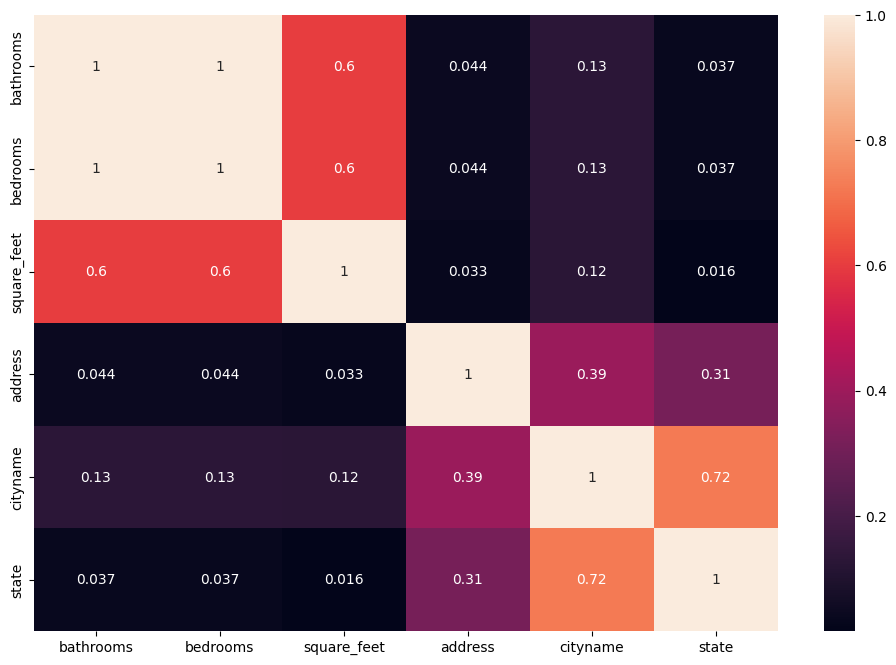

In [395]:
corr = data.corr()
top_features = corr['price_display'].abs() > 0.3 #& (corr['price_display'].abs() < 0.9)
plt.subplots(figsize=(12, 8))
top_corr =  X.loc[:, top_features].corr()
sns.heatmap(top_corr, annot=True)

In [396]:
X = X.loc[:, top_features]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,shuffle=True,random_state=10)
print(X_train)
print(y_train)
X_train.info()

      bathrooms  bedrooms  square_feet      address     cityname        state
5250          1         1          516  1205.942260  1198.559353  1174.961760
7173          3         3         1850  1487.286222  1624.215548  1132.340762
2661          1         1          556  1487.286222  1186.021086  1299.423722
5018          1         1          675  1487.286222  1487.495249  1266.574433
3969          1         1          410  1487.286222  1306.177713  1294.699298
...         ...       ...          ...          ...          ...          ...
4829          2         2         1036  1487.286222  1310.095407  1531.997605
7291          1         1          900  1487.286222  1317.665194  1577.722690
1344          1         1          902  1487.286222  1018.031802  1792.752725
7293          1         1          250  1487.286222  2476.457244  1173.554192
1289          1         1         1050  1019.091873  1019.091873  1294.699298

[7200 rows x 6 columns]
5250    1000
7173    2625
2661    1250


In [397]:
# Scaling the data
#y_train= y_train.values.reshape(-1,1)
#y_test= y_test.values.reshape(-1,1)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
#y_train = sc_X.fit_transform(y_train)
#y_test = sc_y.fit_transform(y_test)

X_train

array([[-0.59699717, -0.59699717, -0.61626102, -1.03273003, -0.50181135,
        -0.60403438],
       [ 2.8582919 ,  2.8582919 ,  1.28757854, -0.00610358,  0.268195  ,
        -0.68684195],
       [-0.59699717, -0.59699717, -0.55917438, -0.00610358, -0.52449291,
        -0.36221948],
       ...,
       [-0.59699717, -0.59699717, -0.06537491, -0.00610358, -0.82838327,
         0.59626055],
       [-0.59699717, -0.59699717, -0.9958872 , -0.00610358,  1.80988881,
        -0.60676912],
       [-0.59699717, -0.59699717,  0.14584567, -1.71454864, -0.82646562,
        -0.37139848]])

In [398]:
#multilevel linear regression - train error
multi_model = linear_model.LinearRegression()
multi_model.fit(X_train, y_train)
prediction = multi_model.predict(X_train)
print('Mean Square Error', metrics.mean_squared_error(y_train, prediction))
r2 = r2_score(y_train, prediction)
acc = r2 * 100
print('Model Accuracy', acc)

Mean Square Error 654038.140265437
Model Accuracy 44.101605198677106


In [399]:
#multilevel linear regression - test error
pred = multi_model.predict(X_test)
print('Mean Square Error', metrics.mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
acc = r2 * 100
print('Model Accuracy', acc)

Mean Square Error 417465.95349291153
Model Accuracy 66.41356801962614


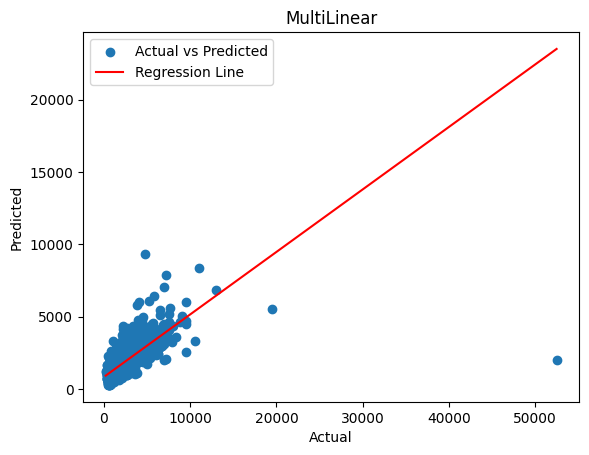

In [400]:
from sklearn.decomposition import PCA

pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())

pipeline.fit(X_train, y_train)

prediction = pipeline.predict(X_train)

# Plotting
plt.scatter(y_train, prediction, label='Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plot the regression line
plt.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, prediction, 1))(np.unique(y_train)), color='red', label='Regression Line')

plt.title('MultiLinear')
plt.legend()
plt.show()

In [401]:
#hyperparameter tuning
param_dist = {'polynomialfeatures__degree': randint(1, 10)}

poly_reg = make_pipeline(PolynomialFeatures(), LinearRegression())

random_search = RandomizedSearchCV(poly_reg, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)

random_search.fit(X_train, y_train)

best_degree = random_search.best_params_['polynomialfeatures__degree']
print("Best degree value:", best_degree)

Best degree value: 2


In [402]:
#polynomial regression - train
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
poly_model = linear_model.LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_train_predicted = poly_model.predict(X_train_poly)
ypred=poly_model.predict(poly_features.transform(X_train))
print(ypred.size)

7200


In [403]:
#polynomial regression - test
y_test_pred = poly_model.predict(poly_features.fit_transform(X_test))
print(y_test_pred.size)

1800


In [404]:
#polynomial regression - train
print('Mean Square Error', metrics.mean_squared_error(y_train, ypred))
r2 = r2_score(y_train, ypred)
acc = r2 * 100
print('Model Accuracy', acc)

Mean Square Error 571602.0901095077
Model Accuracy 51.14713143604248


In [405]:
#polynomial regression - test
print('Mean Square Error', metrics.mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)*100
print('Model Accuracy', r2)

Mean Square Error 316318.7078759635
Model Accuracy 74.55117794084688


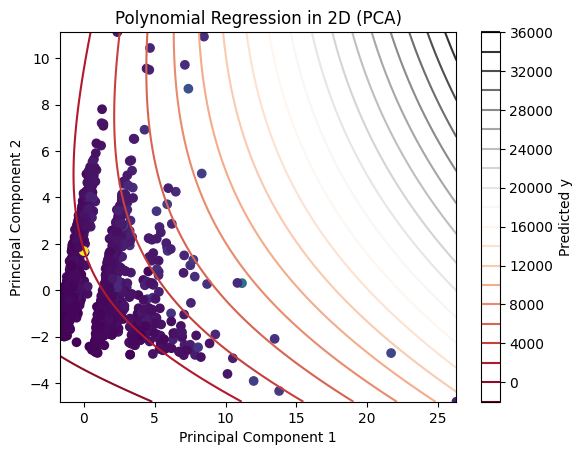

In [406]:
#Visualize the Polynomial Regression line in 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)


poly_features = PolynomialFeatures(degree=2)
X_train_pca_poly = poly_features.fit_transform(X_train_pca)
poly_model = LinearRegression()
poly_model.fit(X_train_pca_poly, y_train)


plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

x_line = np.linspace(X_train_pca[:, 0].min(), X_train_pca[:, 0].max(), 100)
y_line = np.linspace(X_train_pca[:, 1].min(), X_train_pca[:, 1].max(), 100)
x_line, y_line = np.meshgrid(x_line, y_line)
xy_line = np.column_stack((x_line.ravel(), y_line.ravel()))
xy_line_poly = poly_features.transform(xy_line)
z_line = poly_model.predict(xy_line_poly)
z_line = z_line.reshape(x_line.shape)

plt.contour(x_line, y_line, z_line, levels=20, cmap='RdGy')
plt.colorbar(label='Predicted y')
plt.title('Polynomial Regression in 2D (PCA)')
plt.show()

In [407]:
#Random Forest Regression
regressor = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=30, n_jobs=-1, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=30, n_estimators=300,
                      n_jobs=-1, oob_score=True, random_state=0)

In [408]:
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = regressor.predict(X_test)

mse = metrics.mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)*100
print(f'Model Accuracy: {r2}')

Out-of-Bag Score: 0.4980237174318204
Mean Squared Error: 441889.0949326922
Model Accuracy: 64.44865046922243


In [409]:
#Decision Tree Regression

regressor = DecisionTreeRegressor(min_samples_split=30, max_depth=10)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Square Error', metrics.mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)*100
print('Model Accuracy', r2)

Mean Square Error 426849.7573937188
Model Accuracy 65.65861186381359


In [410]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=300, min_samples_split=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Mean Square Error', metrics.mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)*100
print('Model Accuracy', r2)

Mean Square Error 365979.16850505193
Model Accuracy 70.55583971247748
